# Support for a model of neutral evolution in currently available bulk sequencing data


This notebook contains script to reproduce analysis provided in the avove titled paper which appears in ... This is a 
reply to a critique from McDonald, Chakrabarti & Michor on our 2016 Nature Genetic paper "Identification of neutral tumour evolution across cancet types".

In their letter critiquing Williams, Werner et al 2016 McDonald, Chakrabarti & Michor contend that the $R^2$ statistic we used to distinguish neutral from non-neutral tumours has no power. Here I'll show using a simulation of cancer evolution that our method does have power to detect selection provided the effect of selection is strong enough or enough time has elapsed such that sub populations have clonally expanded to observeable frequencies. To demonstrate this I'll generate an idealised dataset where there are no clonal mutations and no normal contamination which are confounding factors in this analysis. This represents an idealised scenario with which to test the power of the $R^2$ statistic.

A second critique is that the size of the populations has an effect on the $R^2$ value in the final section I will show that we cannot recapitulate these results and find no difference in the distribution of $R^2$ values as a function of final population size.

In [131]:
# load all required packages

using CancerSeqSim
using DataFrames
using Distributions
using Colors
using ProgressMeter
using RCall
R"""source("roc_curves.R")""";

## 0. Setup

In [ ]:
#make plots directory using shell

In [127]:
;mkdir plots

mkdir: cannot create directory ‘plots’: File exists


In [128]:
Nsims = 1000

1000

## 1. Synthetic cohort to test power of $R^2$

In [129]:
# constants for all simulations
μ = 8.0
d = 0.5 * log(2) # 50% death rate
clonalmuts = 0
read_depth = 100.0
fmin = 0.05
fmax = 0.5
ρ = 0.0 # no overdispersion
cellularity = 1.0 # 100% purity

1.0

We'll generate a cohort of synthetic tumours with different subclone sizes. Firstly though, here is a single synthetic dataset.

In [146]:
srand(123)
#generate a neutral tumour
targetdata = simulate(nclones = 0, read_depth = read_depth, ρ = ρ,  
    μ = μ, clonalmutations = clonalmuts, d = d, cellularity = cellularity)

Input parameters: 
	 Mutation rate: 16.00
	 Death rate of host population: 0.35
	 Effective mutation rate (μ/β): 32.00
	 Number of clonal mutation: 0
	 Number of subclones: 0

No clones, tumour growth was neutral



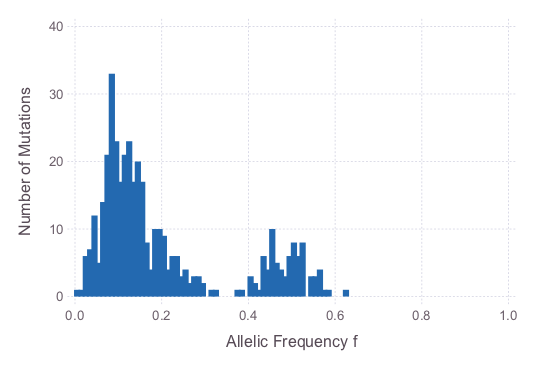

In [147]:
vafhistogram(targetdata)

In [148]:
#generate a tumour with a single subclone with subclone frequency between 0.2 and 0.8
targetdata = simulate(0.2, 0.8, nclones = 1, read_depth = read_depth, ρ = ρ,  
    μ = μ, clonalmutations = clonalmuts, d = d, cellularity = cellularity)

Input parameters: 
	 Mutation rate: 8.00
	 Death rate of host population: 0.35
	 Effective mutation rate (μ/β): 16.00
	 Number of clonal mutation: 0
	 Number of subclones: 1

Subclone 1 
	Frequency: 0.66
	Number of mutations in subclone: 129
	Fitness advantage: 1.75
	Time subclone emerges (population doublings): 6.77
	Number of divisions: 14
	Average number of divisions per cell: 12.89
	Population size when subclone emerges: 109
	Parent of subclone (0 is host): 0


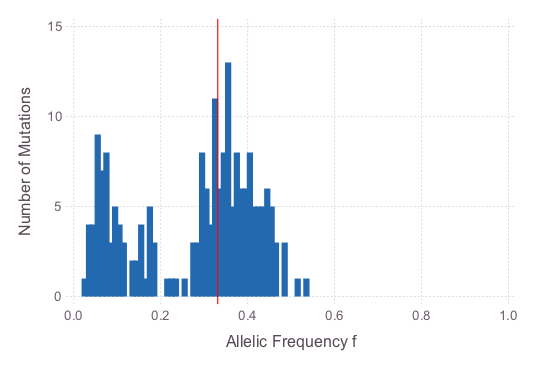

In [149]:
#red line shows frequency of subclone
vafhistogram(targetdata, annotateclones = true)

In [130]:
# Generate cohort of simulations, adding set of neutral simulations for each clonesize so we can produce roc curves
# simulate function will return a simulated dataset with a subclone in the frequency range

srand(123) # seed the random number generator so figure is reproducible
rsq = Float64[]
Nclones = String[]
clonesize = String[]
clonesizevec = Float64[]
Nmuts = Int64[]
srand(1234)
@showprogress for i in 1:Nsims  
    #first generate Nsims neutral simaulations
    targetdata = simulate(nclones = 0, read_depth = read_depth, ρ = ρ,  
    μ = μ, clonalmutations = clonalmuts, d = d, cellularity = cellularity);
    DF = getsummary(targetdata, fmin = fmin, fmax = fmax)
    push!(rsq, Array(DF[:rsq])[1])
    push!(Nclones, "Neutral")
    push!(clonesizevec, 0.0)
end

#copy neutral simulations for each clone size
Nclones = repeat(Nclones, inner = 3)
clonesizevec = repeat(clonesizevec, inner = 3)
rsq = repeat(rsq, inner = 3)
clonesize = [repeat(["0.1 < CCF < 0.9"], inner = Nsims);
    repeat(["0.2 < CCF < 0.8"], inner = Nsims);
    repeat(["0.3 < CCF < 0.7"], inner = Nsims)]

srand(1234)
@showprogress for i in 1:Nsims 
    #now generate Nsims non-neutral simaulations with subclone size 0.1 < CCF < 0.9
    targetdata = simulate(0.1, 0.9, nclones = 1, read_depth = read_depth, ρ = ρ,  
    μ = μ, clonalmutations = clonalmuts, d = d, cellularity = cellularity);
    DF = getsummary(targetdata, fmin = fmin, fmax = fmax)
    push!(rsq, Array(DF[:rsq])[1])
    push!(Nclones, "1 Clone")
    push!(clonesize, "0.1 < CCF < 0.9")
    push!(Nmuts, length(targetdata.sampleddata.VAF))
    push!(clonesizevec, targetdata.output.clonefreq[1])
end

@showprogress for i in 1:Nsims
    #now generate Nsims non-neutral simaulations with subclone size 0.2 < CCF < 0.8
    targetdata = simulate(0.2, 0.8, nclones = 1, read_depth = read_depth, ρ = ρ,  
    μ = μ, clonalmutations = clonalmuts, d = d, cellularity = cellularity);
    DF = getsummary(targetdata, fmin = fmin, fmax = fmax)
    push!(rsq, Array(DF[:rsq])[1])
    push!(Nclones, "1 Clone")
    push!(clonesize, "0.2 < CCF < 0.8")
    push!(Nmuts, length(targetdata.sampleddata.VAF))
    push!(clonesizevec, targetdata.output.clonefreq[1])
end

@showprogress for i in 1:Nsims
    #now generate Nsims non-neutral simaulations with subclone size 0.3 < CCF < 0.7
    targetdata = simulate(0.3, 0.7, nclones = 1, read_depth = read_depth, ρ = ρ,  
    μ = μ, clonalmutations = clonalmuts, d = d, cellularity = cellularity);
    DF = getsummary(targetdata, fmin = fmin, fmax = fmax)
    push!(rsq, Array(DF[:rsq])[1])
    push!(Nclones, "1 Clone")
    push!(clonesize, "0.3 < CCF < 0.7")
    push!(Nmuts, length(targetdata.sampleddata.VAF))
    push!(clonesizevec, targetdata.output.clonefreq[1])
end

DF = DataFrame(rsq = 1 - rsq, Nclones = Nclones, clonesize = clonesize, clonesizevalue = clonesizevec);
@rput DF;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24
Progress: 100%|█████████████████████████████████████████| Time: 0:02:55
Progress: 100%|█████████████████████████████████████████| Time: 0:03:49
Progress: 100%|█████████████████████████████████████████| Time: 0:05:41


With this data we'll make boxplot of $R^2$ as a funtion of clone size

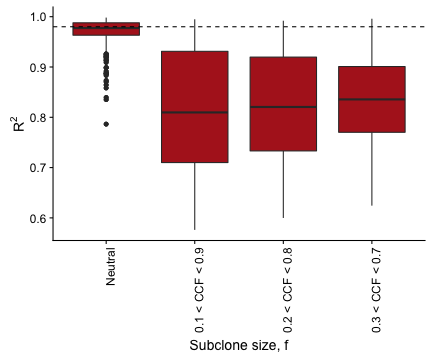

RCall.RObject{RCall.VecSxp}


In [150]:
R"""

df <- DF
dftemp <- df %>%
filter(Nclones == "Neutral" & clonesize == "0.1 < CCF < 0.9")
df <- rbind(dftemp, filter(df, Nclones == "1 Clone"))

dftemp <- df %>%
filter(Nclones == "Neutral" & clonesize == "0.1 < CCF < 0.9")
df <- rbind(dftemp, filter(df, Nclones == "1 Clone")) %>%
mutate(clonesize = ifelse(Nclones == "1 Clone", clonesize, "Neutral"))
head(dftemp)

df$clonesize <- factor(df$clonesize, levels = c("Neutral",
                                                "0.1 < CCF < 0.9",
                                                "0.2 < CCF < 0.8",
                                                "0.3 < CCF < 0.7" ))

g <- ggplot(df, aes(y = 1 - rsq, x = clonesize)) + 
    geom_boxplot(fill = "firebrick") +  
    xlab("Subclone size, f") +
    ylab(expression(R^2)) +
    scale_fill_ptol() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    theme(legend.title=element_blank()) +
    geom_hline(yintercept = 0.98, lty = 2)

ggsave(filename = "plots/rsq_boxplot.pdf", g)
gboxplot <- g
gboxplot
"""

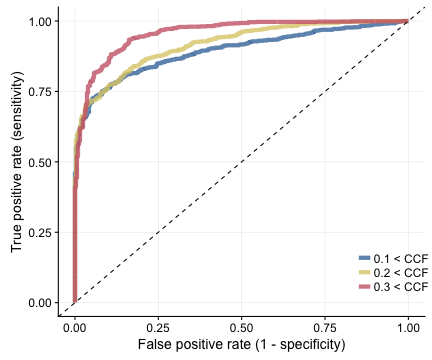

RCall.RObject{RCall.VecSxp}


In [151]:
R"""out <- roccurve(DF)
dfroc <- out[[3]]
auc <- out[[2]]

groc <- out[[1]] + 
        theme(legend.position = c(0.8, 0.15)) +
        background_grid(major = "xy", minor = "none") 
        

ggsave(filename = "plots/rsq_roc.pdf", groc)
groc
"""

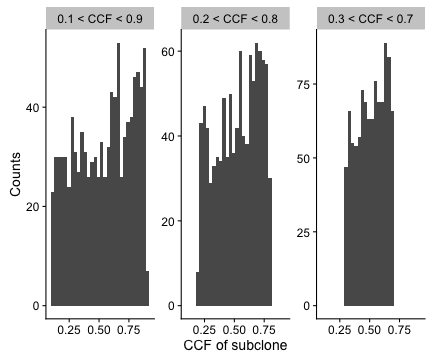

RCall.RObject{RCall.VecSxp}


In [152]:
# as a sanity check we'll make sure that the distribution of clone sizes is approximately uniform across the range so that 
# the R^2 metrics is not biased. There is a slight bias toward larger subclone sizes but overall the distribution has a large
# number of simulations across the range

R"""
g <- df %>%
filter(clonesize != "Neutral") %>%
ggplot(aes(x = clonesizevalue)) +
geom_histogram() + facet_wrap(~clonesize, scales = "free_y") +
xlab("CCF of subclone") + ylab("Counts")
"""

We'll now make the figure we included in our reply

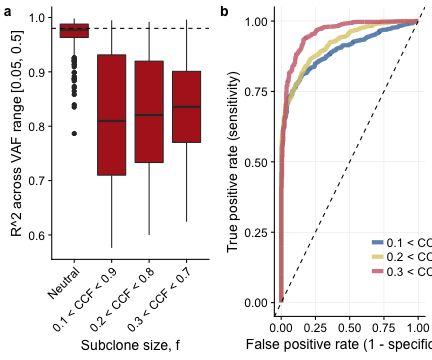

RCall.RObject{RCall.VecSxp}


In [153]:
R"""
p1 <- plot_grid(gboxplot + ylab(paste0(expression(R^2), " across VAF range [0.05, 0.5]")) + 
                    theme(axis.text.x=element_text(angle=45,hjust=1)), 
                    groc + theme(legend.position = c(0.6, 0.2)), labels = c("a", "b")) 


save_plot("plots/figure1.pdf", p1, base_height = 5, base_width = 10)
p1
"""

## 2.0 Difference in $R^2$ in different population sizes

In [159]:
srand(123)
Nsims = 500

rsq = Float64[]
popsize = String[]
clonesize = String[]
@showprogress for i in 1:Nsims
    
    #first generate Nsims neutral simaulations
    targetdata = simulate(nclones = 0, ρ = ρ, Nmax = 10^3,
    μ = μ, clonalmutations = clonalmuts, d = d, cellularity = cellularity);
    DF = getsummary(targetdata, fmin = fmin, fmax = fmax)
    push!(rsq, Array(DF[:rsq])[1])
    push!(popsize, "10^3")
end

@showprogress for i in 1:Nsims
    
    #first generate Nsims neutral simaulations
    targetdata = simulate(nclones = 0, ρ = ρ, Nmax = 10^4,
    μ = μ, clonalmutations = clonalmuts,  d = d, cellularity = cellularity);
    DF = getsummary(targetdata, fmin = fmin, fmax = fmax)
    push!(rsq, Array(DF[:rsq])[1])
    push!(popsize, "10^4")
end

@showprogress for i in 1:Nsims
    
    #first generate Nsims neutral simaulations
    targetdata = simulate(nclones = 0, ρ = ρ, Nmax = 10^5,
    μ = μ, clonalmutations = clonalmuts, d = d, cellularity = cellularity);
    DF = getsummary(targetdata, fmin = fmin, fmax = fmax)
    push!(rsq, Array(DF[:rsq])[1])
    push!(popsize, "10^5")
end

DFpop = DataFrame(rsq = rsq, popsize = popsize);
@rput DFpop;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:16
Progress: 100%|█████████████████████████████████████████| Time: 0:07:14


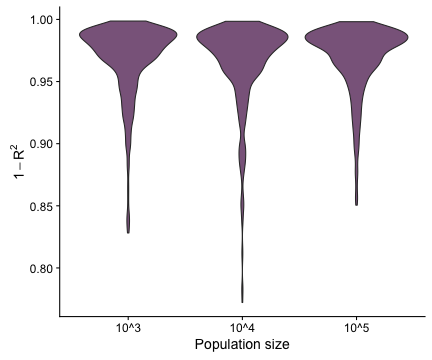

RCall.RObject{RCall.VecSxp}


In [160]:
R"""
DFpop %>%
ggplot(aes(x = popsize, y = rsq)) +
geom_violin(fill = "plum4") +
ylab(expression(1 - R^2)) +
xlab("Population size")
"""